# Libraries

In [1]:
import numpy as np 
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

# Import Data

In [2]:
names = ['X_robot','Y_robot','Orientation_robot','Collision','X_candle1','Y_candle1','X_candle2','Y_candle2', 'X_candle3', 'Y_candle3','X_candle4','Y_candle4','X_speed','Y_speed']
robotdata = pd.read_csv('RobotData.csv', names=names)

robotdata.head()

,X_robot,Y_robot,Orientation_robot,Collision,X_candle1,Y_candle1,X_candle2,Y_candle2,X_candle3,Y_candle3,X_candle4,Y_candle4,X_speed,Y_speed
0,3.955138,11.870423,-2.708559,0,1.566351,10.681844,2.69308,6.687333,0.187108,1.678316,8.4906,9.150135,-0.118001,-0.054551
1,4.000958,4.238834,1.812858,0,1.566351,10.681844,2.69308,6.687333,0.187108,1.678316,8.4906,9.150135,-0.031162,0.126210
2,8.755436,2.019115,-1.135413,0,1.566351,10.681844,2.69308,6.687333,0.187108,1.678316,8.4906,9.150135,0.054829,-0.117872
3,11.098697,0.086990,0.044513,0,1.566351,10.681844,2.69308,6.687333,0.187108,1.678316,8.4906,9.150135,0.129871,0.005785
4,10.049046,5.131111,-1.354733,0,1.566351,10.681844,2.69308,6.687333,0.187108,1.678316,8.4906,9.150135,0.027870,-0.126977


# Simple Data understanding

Missing values detected in dataframe: False


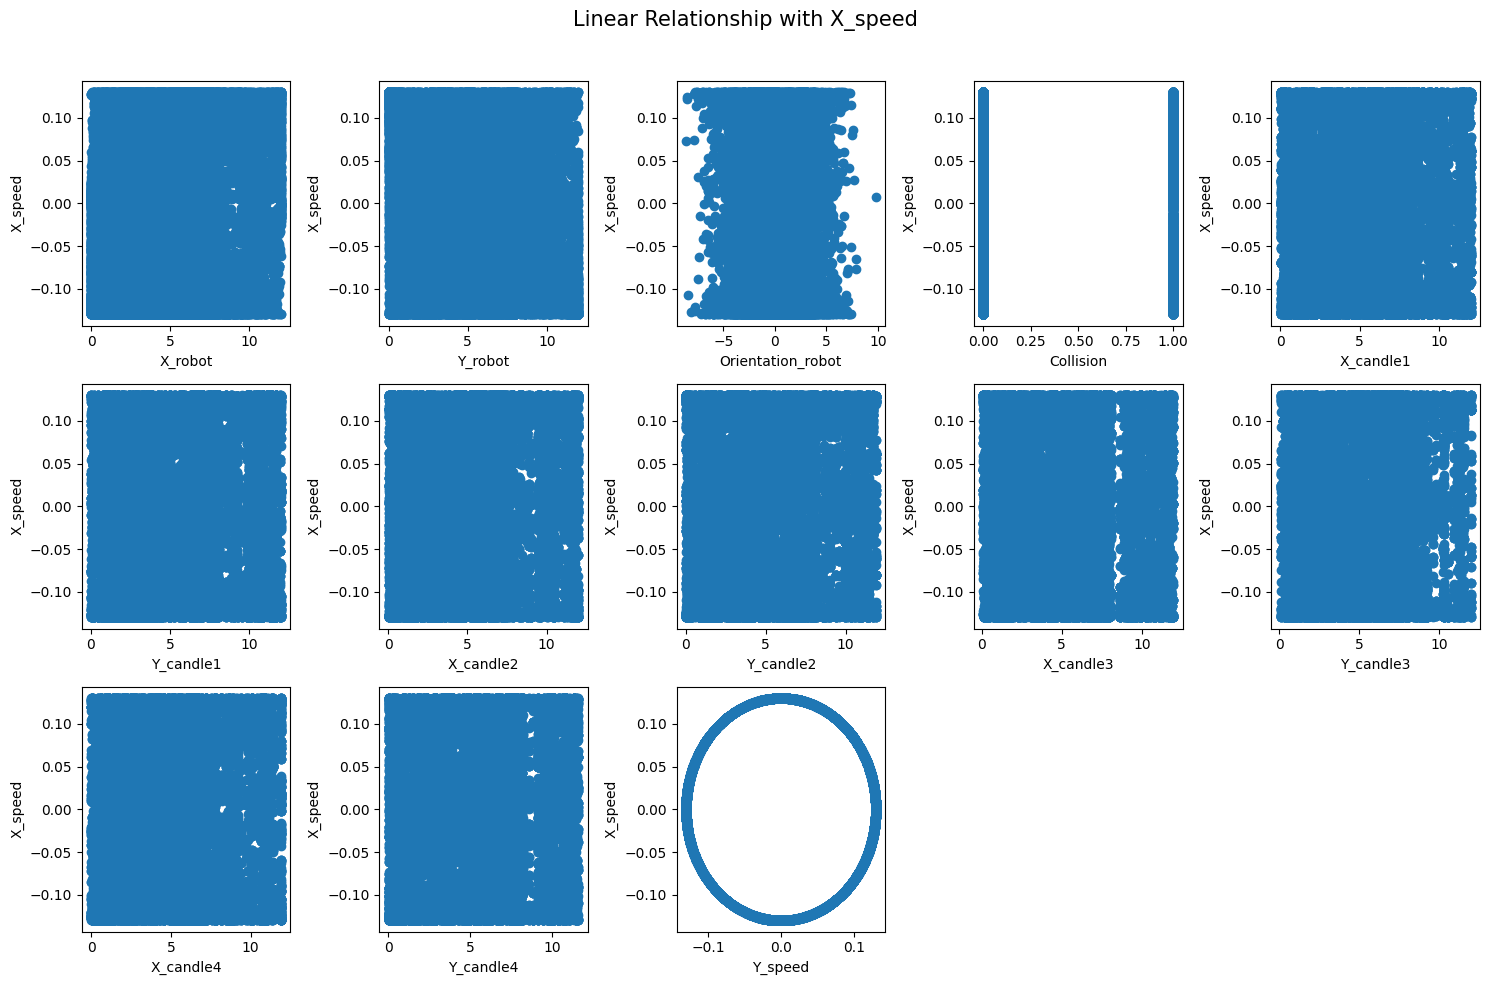

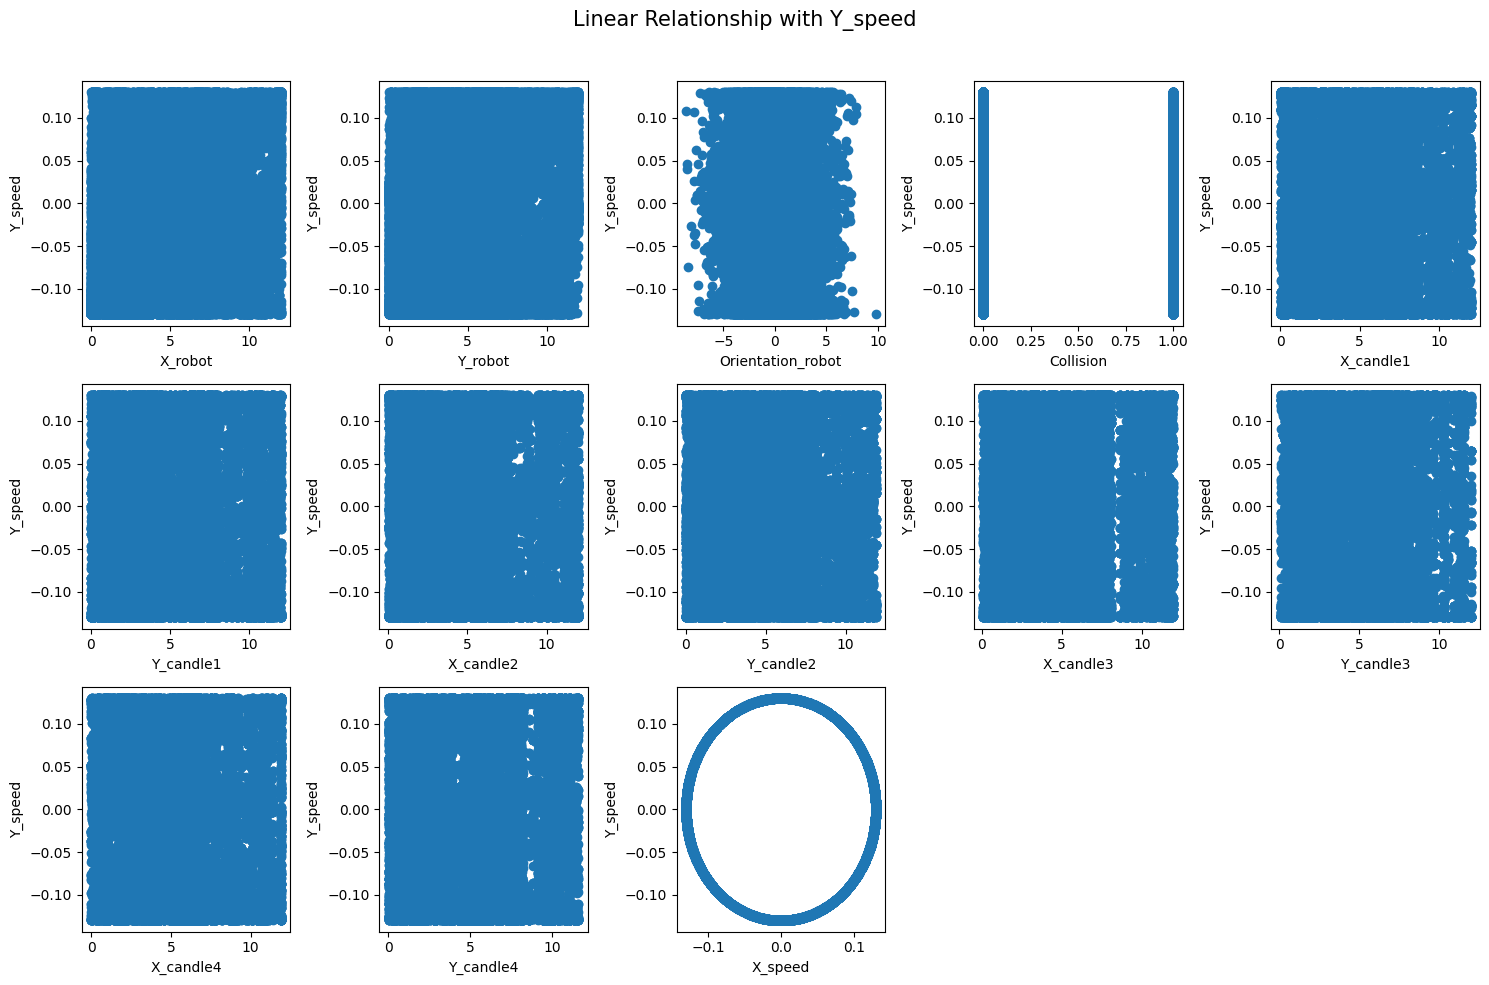

In [3]:
def scatterplots(col):
    x_sc = robotdata.drop(columns=[col])
    y_sc = robotdata[col]

    n_features = len(x_sc.columns)
    n_cols = 5
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,10))
    fig.suptitle(f'Linear Relationship with {col}', fontsize=15)

    ax = ax.flatten()

    for i in range(n_features):
        ax[i].scatter(x_sc.iloc[:,i], y_sc)
        ax[i].set_xlabel(x_sc.columns[i])
        ax[i].set_ylabel(col)

    for j in range(n_features, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print(f'Missing values detected in dataframe: {robotdata.isnull().values.any()}') #False so no data imputation needed

scatterplots('X_speed')
scatterplots('Y_speed')

#visualisations indicate data is non-linear

# Pre-processing

In [4]:
def standardise(xtrain,xtest):
    scaler = StandardScaler()

    xtrainscaled = scaler.fit_transform(xtrain)
    xtestscaled = scaler.transform(xtest)

    return scaler, xtrainscaled, xtestscaled

def calculateDistance(df, xrobot, yrobot, xcandle, ycandle):
    return np.sqrt((df[xcandle] - df[xrobot])**2 + (df[ycandle] - df[yrobot])**2)

def calculateAngleToCandle(df, xcandle, ycandle, xrobot, yrobot):
    return np.arctan2(df[ycandle] - df[yrobot], df[xcandle] - df[xrobot])

def calculateRelativeAngle(df, angletocandle, orientation):
    return angletocandle - df[orientation] 

def calculateCentroid(df, xcandles, ycandles):
    x_centroid = df[xcandles].mean(axis=1)
    y_centroid = df[ycandles].mean(axis=1)

    return x_centroid, y_centroid

def feature_engineering(df):
    df_copy = df.copy()

    #Calculate centroid of candle positions
    x_candles = ['X_candle1', 'X_candle2', 'X_candle3', 'X_candle4']
    y_candles = ['Y_candle1', 'Y_candle2', 'Y_candle3', 'Y_candle4']

    df_copy['X_centroid'], df_copy['Y_centroid'] = calculateCentroid(df_copy, x_candles, y_candles)

    #Distance from robot to centroid
    df_copy['Distance_to_centroid'] = calculateDistance(df_copy, 'X_robot', 'Y_robot', 'X_centroid', 'Y_centroid')

    for i in range(1,5):
        #Distance between candle and robot
        df_copy[f'Distance_to_candle{i}'] = calculateDistance(df_copy, 'X_robot', 'Y_robot', f'X_candle{i}', f'Y_candle{i}')

        #Angle between candle and robot
        df_copy[f'Angle_to_candle{i}'] = calculateAngleToCandle(df_copy, f'X_candle{i}', f'Y_candle{i}', 'X_robot', 'Y_robot')

        #Relative angle to each candle
        df_copy[f'Relative_angle_to_candle{i}'] = calculateRelativeAngle(df_copy, df_copy[f'Angle_to_candle{i}'], 'Orientation_robot')

    #Proximity to closest candle
    df_copy['Min_distance_to_candle'] = df_copy[['Distance_to_candle1',
                                                'Distance_to_candle2',
                                                'Distance_to_candle3',
                                                'Distance_to_candle4']].min(axis=1)
    
    #Aligment with closest candle
    df_copy['Closest_candle_angle'] = df_copy[['Relative_angle_to_candle1',
                                                'Relative_angle_to_candle2',
                                                'Relative_angle_to_candle3',
                                                'Relative_angle_to_candle4']].min(axis=1)
    
    # Combine these proxies to create a "movement efficiency" score
    df_copy['Movement_efficiency'] = np.exp(-df_copy['Min_distance_to_candle']) * np.cos(df_copy['Closest_candle_angle'])

    #reorder columns to keep target variables as last two columns
    features = ['Distance_to_candle1', 'Distance_to_candle2', 'Distance_to_candle3', 'Distance_to_candle4',
                'X_centroid', 'Y_centroid', 'Distance_to_centroid', 'Min_distance_to_candle',
                'Angle_to_candle1', 'Angle_to_candle2', 'Angle_to_candle3', 'Angle_to_candle4',
                'Relative_angle_to_candle1', 'Relative_angle_to_candle2', 'Relative_angle_to_candle3', 
                'Relative_angle_to_candle4', 'Closest_candle_angle', 'Movement_efficiency']

    for feature in features: 
        column_to_move = df_copy.pop(feature)
        df_copy.insert(df_copy.columns.get_loc('Y_candle4') + 1, feature, column_to_move)

    return df_copy

# Helper functions

In [5]:
def calculateSquaredErrors(trainactual, testactual, trainpredict, testpredict):
    msetrain = mean_squared_error(trainactual, trainpredict)
    msetest = mean_squared_error(testactual, testpredict)

    rmsetrain = np.sqrt(msetrain)
    rmsetest = np.sqrt(msetest)
        
    return msetrain, msetest, rmsetrain, rmsetest

def getModelScore(model, trainscaled, testscaled, train, test):
    trainscore = model.score(trainscaled, train)
    testscore = model.score(testscaled, test)

    return trainscore, testscore

def tabulateMetrics(scoretrain, scoretest, msetrain, msetest, rmsetrain, rmsetest):
    metrics =[[scoretrain, scoretest, msetrain, msetest, rmsetrain, rmsetest]]
    headers = ['Train Score', 'Test Score', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE']
    print(tabulate(metrics, headers=headers, tablefmt='fancy_outline', numalign='center', floatfmt='.5f'))

def saveObjects(directory, model, scaler):
    with open(os.path.join(directory, 'othermodel3.pkl'), 'wb') as f:
        pickle.dump(model, f)

    with open(os.path.join(directory, 'otherscaler3.pkl'), 'wb') as f:
        pickle.dump(scaler, f)

def loadObjects(directory):
    model = pickle.load(open(os.path.join(directory, 'othermodel3.pkl'), 'rb'))
    scaler = pickle.load(open(os.path.join(directory, 'otherscaler3.pkl'), 'rb'))

    return model, scaler

# Develop and Evaluate


In [6]:
#if mode is 'develop', it means that we will use the available data for training our model
#if mode is 'evaluate', it means that we will load the model that was trained before (as well as any operators for data pre-processing) to make prediction on novel data
mode = 'develop'

#How many outputs (i.e., columns) your model should predict
num_outputs = 2

#Define the directory where the objects will be saved
directory = "OtherModel3Objects"

#Ensure the directory exists
os.makedirs(directory, exist_ok=True)

if mode == 'develop':
    # Feature engineering
    robotdata = feature_engineering(robotdata)
    
    X = robotdata.iloc[:, :-num_outputs]  # inputs
    y = robotdata.iloc[:, -num_outputs:]  # outputs
    
    # Split into 80% train and 20% test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

    # Standardize
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define Model
    model = KNeighborsRegressor()

    # Define Parameter Grid for GridSearchCV
    param_grid = {
        'weights': ['uniform', 'distance'],
        'p': [1,2],
        'leaf_size': [20,30,40]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=10,  
        verbose=1,
        n_jobs=-1  # Use all available cores for faster processing
    )

    # Fit GridSearchCV
    grid_search.fit(x_train_scaled, y_train)

    # Get Best Model and Parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score}")

    # Predictions
    y_train_pred = best_model.predict(x_train_scaled)
    y_test_pred = best_model.predict(x_test_scaled)

    # Calculate Metrics
    train_score, test_score = getModelScore(best_model, x_train_scaled, x_test_scaled, y_train, y_test)
    mse_train, mse_test, rmse_train, rmse_test = calculateSquaredErrors(y_train, y_test, y_train_pred, y_test_pred)

    # Print Metrics
    tabulateMetrics(train_score, test_score, mse_train, mse_test, rmse_train, rmse_test)

    #save objects
    saveObjects(directory, best_model, scaler)

elif mode == 'evaluate':
    #load objects
    model, scaler = loadObjects(directory)
    
    # Read novel data. This data usually has no output y. You'll need to use your model to predict y
    novel_data = pd.read_csv('novel_data_here')

    #apply feature engineering
    X_novel_feature_engineered = feature_engineering(novel_data)

    #standardise
    X_novel_scaled = scaler.transform(X_novel_feature_engineered)

    #predict
    y_pred = model.predict(X_novel_scaled)
    print("Prediction Complete")

    #save prediction to csv
    pd.DataFrame(y_pred).to_csv('prediction.csv')


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.5434918771788879
╒═══════════════╤══════════════╤═════════════╤════════════╤══════════════╤═════════════╕
│  Train Score  │  Test Score  │  Train MSE  │  Test MSE  │  Train RMSE  │  Test RMSE  │
╞═══════════════╪══════════════╪═════════════╪════════════╪══════════════╪═════════════╡
│    1.00000    │   0.54541    │   0.00000   │  0.00384   │   0.00000    │   0.06193   │
╘═══════════════╧══════════════╧═════════════╧════════════╧══════════════╧═════════════╛
